In [1]:
import numpy as np
import matplotlib.pyplot as plt

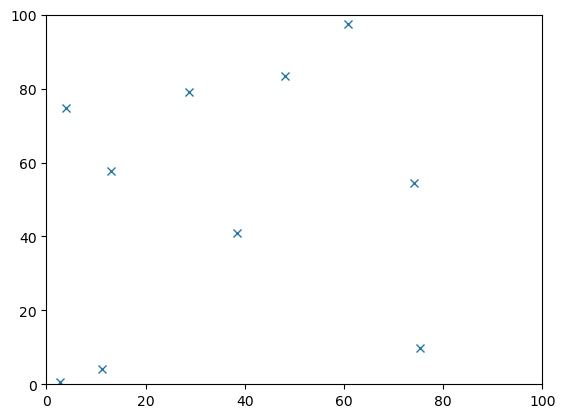

In [2]:
# Map
seed = 1338
x_dim, y_dim = 100, 100
num_landmarks = 10
landmarks = np.hstack((np.random.RandomState(seed).rand(num_landmarks, 2) * np.array([x_dim, y_dim]), \
    np.arange(num_landmarks).reshape(-1, 1)))
fov = 360 # field of view

plt.xlim(0, x_dim)
plt.ylim(0, y_dim)
plt.plot(landmarks[:, 0], landmarks[:, 1], 'x')

![](EKF.png)

In [3]:
# EKF SLAM implementation
# initialize

In [4]:
Rt = np.array([[0.1,   0,   0], 
                [  0, 0.1,   0],
                [  0,   0, 0.1]]) # Robot motion noise
Qt = np.array([[0.1,   0],
                [  0, 0.1]]) # Landmark measurement noise
x = np.array([50, 20, 0]) # Initial robot pose

timestep = 1
x_hat = np.zeros((3 + 2 * num_landmarks, 1)) # mu, Initial state x, y, theta, x1, y1, x2, y2, ...
x_hat[:3] = x.reshape(-1, 1)
P_hat = np.zeros((3 + 2 * num_landmarks, 3 + 2 * num_landmarks)) # sigma0
P_hat[3:, 3:] = np.eye(2*num_landmarks)*1e6 # set intial covariance for landmarks to large value

In [5]:
from ekf import EKF
from robot import Robot
ekf = EKF()
robot = Robot(fov, 100)

# simulate
u = np.array([1, 0])
while True:
    # move robot
    # predict
    # sense
    # update
    # plot
    # 

    # move
    # x = robot.move(x, u, Rt)
    # predict
    x_hat, P_hat = ekf.predict(x_hat, u, P_hat, Rt)
    # sense
    z = robot.sense(landmarks, x_hat, Qt)

    # update
    x_hat, P_hat = ekf.update(x_hat, P_hat, z, Qt)
    
    # plot
    plt.cla()
    plt.xlim(0, x_dim)
    plt.ylim(0, y_dim)
    plt.plot(landmarks[:, 0], landmarks[:, 1], 'x')
    plt.plot(x_hat[0], x_hat[1], 'o')
    plt.plot(x_hat[3::2], x_hat[4::2], 'o')
    plt.pause(0.1)

c:\Users\simen\Git\Project-fall22\tests\ekf.py:13: RuntimeWarning: divide by zero encountered in long_scalars
  T = np.array([[-v/omega*np.sin(theta) + v/omega*np.sin(theta + omega*timestep)],
c:\Users\simen\Git\Project-fall22\tests\ekf.py:13: RuntimeWarning: invalid value encountered in double_scalars
  T = np.array([[-v/omega*np.sin(theta) + v/omega*np.sin(theta + omega*timestep)],
c:\Users\simen\Git\Project-fall22\tests\ekf.py:14: RuntimeWarning: divide by zero encountered in long_scalars
  [v/omega*np.cos(theta) - v/omega*np.cos(theta + omega*timestep)],
c:\Users\simen\Git\Project-fall22\tests\ekf.py:14: RuntimeWarning: invalid value encountered in double_scalars
  [v/omega*np.cos(theta) - v/omega*np.cos(theta + omega*timestep)],
c:\Users\simen\Git\Project-fall22\tests\ekf.py:28: RuntimeWarning: divide by zero encountered in long_scalars
  T = np.array([[0, 0, -v/omega*np.cos(theta) + v/omega*np.cos(theta + omega*timestep)],
c:\Users\simen\Git\Project-fall22\tests\ekf.py:28: Runtim

ValueError: operands could not be broadcast together with shapes (3,3) (23,23) 

In [ ]:
def g(u, x, Fx, timestep=1): 
    """Motion model
    u: control input [v, w]
    x: state [x, y, theta, x1, y1, x2, y2, ...] (it's x_(t-1) )"""
    x, y, theta = x[0], x[1], x[2]
    v, omega = u[0], u[1]

    T = np.array([[-v/omega*np.sin(theta) + v/omega*np.sin(theta + omega*timestep)],
                    [v/omega*np.cos(theta) - v/omega*np.cos(theta + omega*timestep)],
                    [omega*timestep]])

    return x + Fx.T @ T

In [ ]:
def jacobian(u, x, Fx, timestep=1):
    """Jacobian of motion model
    u: control input [v, w]
    x: state [x, y, theta, x1, y1, x2, y2, ...]"""
    x, y, theta = x[0], x[1], x[2]
    v, omega = u[0], u[1]

    T = np.array([[0, 0, -v/omega*np.cos(theta) + v/omega*np.cos(theta + omega*timestep)],
                  [0, 0, -v/omega*np.sin(theta) + v/omega*np.sin(theta + omega*timestep)],
                  [0, 0 , 0]])

    return np.eye(3) + Fx.T @ T @ Fx

In [ ]:
def P_hat(Gt, Rt, P, Fx):
    """Covariance update"""
    return Gt @ P @ Gt.T + Fx.T @ Rt @ Fx

In [ ]:
def predict(u, x, P, Fx, Rt, timestep=1):
    """Predict step"""
    x_hat = g(u, x, Fx, timestep)
    Gt = jacobian(u, x, Fx, timestep)
    P_hat = P_hat(Gt, Rt, P, Fx)
    return x_hat, P_hat

In [ ]:
def update(x_hat, P_hat, z, Qt, Fx, threshold=1e6):
    """Update step
    x_hat: state [x, y, theta, x1, y1, x2, y2, ...],  shape (3 + 2 * num_landmarks, 1)
    P_hat: covariance matrix, shape (3 + 2 * num_landmarks, 3 + 2 * num_landmarks)
    z: measurement [range r, bearing theta, landmark index j], shape: (3, num_landmarks)
    Qt: measurement noise, shape: (2, 2)
    Fx: Jacobian of motion model, shape: (3, 3 + 2 * num_landmarks)
    """
    for r, theta, j in z:
        j = int(j)
        if P_hat[3 + 2*j, 3 + 2*j] >= threshold and P_hat[3 + 2*j + 1, 3 + 2*j + 1] >= threshold:
            # initialize landmark
            x_hat[3 + 2*j, 0] = x_hat[0, 0] + r * np.cos(x_hat[2, 0] + theta)
            x_hat[3 + 2*j + 1, 0] = x_hat[1, 0] + r * np.sin(x_hat[2, 0] + theta)
    
        # Distance between robot and landmark
        delta = np.array([[x_hat[3 + 2*j, 0] - x_hat[0, 0]],
                            [x_hat[3 + 2*j + 1, 0] - x_hat[1, 0]]])

        # Measurement estimate from robot to landmark
        q = delta.T @ delta
        z_hat = np.array([[np.sqrt(q)],
                            [np.arctan2(delta[1, 0], delta[0, 0]) - x_hat[2, 0]]])

        # Jacobian of measurement model
        H = (np.array([[-np.sqrt(q)*delta[0, 0], -np.sqrt(q)*delta[1, 0], 0, np.sqrt(q)*delta[0, 0], np.sqrt(q)*delta[1, 0]],
                        [delta[1, 0], -delta[0, 0], -q, -delta[1, 0], delta[0, 0]]]) / q) @ Fx

        # Kalman gain
        K = P_hat @ H.T @ np.linalg.inv(H @ P_hat @ H.T + Qt)

        # Update state and covariance
        x_hat = x_hat + K @ (np.array([[r], [theta]]) - z_hat)
        P_hat = (np.eye(3 + 2 * num_landmarks) - K @ H) @ P_hat
    return x_hat, P_hat